In [178]:
%matplotlib inline

In [179]:
import numpy as np
import pandas as pd

In [180]:
import cv2

In [181]:
import matplotlib.pyplot as plt

In [182]:
import config
from utils.io import load_pickle
from utils.torch.datasets import PathologicalImagesDataset, PathologicalImagesDatasetMode
from utils.scoring import topcoder_metric
from utils.postprocessing import morph_masks
from utils.plotting import plot_mask
from predict import get_prediction_filename

# Load dataset

In [198]:
nb_folds = 5
fold_number = 0
model_name = 'unet_ds'
patch_size_train = 0
patch_size_predict = 0
use_dice = False
use_tta = True

In [199]:
mode = PathologicalImagesDatasetMode.Val
base_dir = config.DATASET_TRAIN_DIR

In [200]:
dataset = PathologicalImagesDataset(base_dir, mode=mode, nb_folds=nb_folds, fold_number=fold_number)

In [201]:
images = [dataset[i][0] for i in range(len(dataset))]
masks = [dataset[i][1] for i in range(len(dataset))]

In [202]:
images = np.stack(images)
masks = np.stack(masks)

In [203]:
images.shape, masks.shape

((34, 500, 500, 3), (34, 500, 500))

## Load predictions

In [204]:
filename = get_prediction_filename(model_name, mode, patch_size_train, patch_size_predict,fold_number, use_dice, use_tta)
_, predictions = load_pickle(filename)

In [229]:
threshold = 0.4

In [230]:
predictions_mask = np.zeros_like(predictions)
predictions_mask[predictions>threshold] = 1

In [231]:
predictions.shape, predictions_mask.shape

((34, 500, 500), (34, 500, 500))

## Get score

In [232]:
score = topcoder_metric(masks, predictions_mask)

In [233]:
print('Score:', score)

Score: 876065.324734


# Post-processing

In [226]:
scores = []
for kernel_size in range(1,20, 2):
    predictions_mask_opened = morph_masks(predictions_mask, kernel_size, operation='open')
    predictions_mask_closed = morph_masks(predictions_mask, kernel_size, operation='close')    
    predictions_mask_opened_closed = morph_masks(
        morph_masks(predictions_mask, kernel_size, operation='open'),
        kernel_size, operation='close'
    )

    
    score_opened = topcoder_metric(masks, predictions_mask_opened)
    score_closed = topcoder_metric(masks, predictions_mask_closed)
    score_opened_closed = topcoder_metric(masks, predictions_mask_opened_closed)    
    
    scores.append({'score_open': score_opened, 'score_close': score_closed, 'score_open_close': score_opened_closed, 'kernel_size': kernel_size})

scores = pd.DataFrame(scores)

In [227]:
scores

,kernel_size,score_close,score_open,score_open_close
0,1,870827.740144,870827.740144,870827.740144
1,3,870741.946297,870971.424378,870923.311305
2,5,870588.834097,871169.503298,871052.088333
3,7,870453.060809,871428.699348,871243.467607
4,9,870005.819752,871667.069824,871126.529957
5,11,869368.915136,871962.516900,871103.916688
6,13,868482.443182,872264.757375,870755.045577
7,15,867523.992917,872292.430902,870170.355476
8,17,866317.634699,871665.125806,868840.255859
9,19,864719.730376,871311.315141,867196.341963


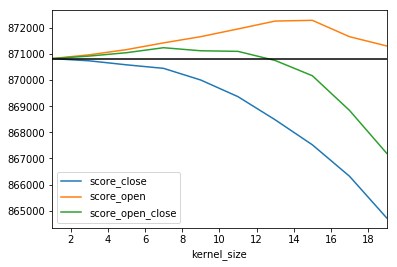

In [228]:
ax = scores.plot(x='kernel_size', y=['score_close', 'score_open', 'score_open_close'])
ax.axhline(y=score, c='black')

In [172]:
# 0 - 13
# 1 - 6
# 2 - 13
# 3 - 9
# 4 - 17

In [173]:
(13 + 6 + 13 + 9 + 17) / 5

11.6

# Plot some masks

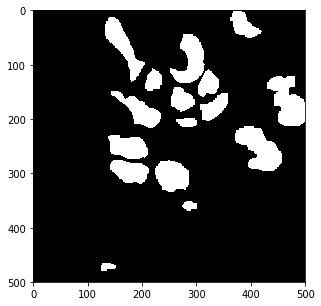

In [174]:
plot_mask(masks[1])

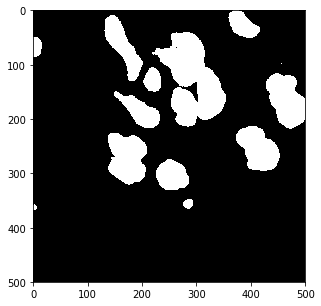

In [175]:
plot_mask(predictions_mask[1])

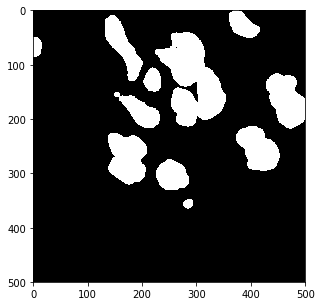

In [176]:
plot_mask(morph_masks(predictions_mask[1], kernel_size=11))

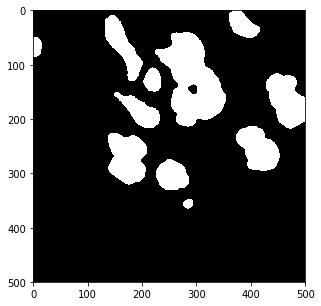

In [177]:
plot_mask(morph_masks(morph_masks(predictions_mask[1], kernel_size=11), kernel_size=11, operation='close'))